In [1]:
import json
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 18

In [192]:
s = "UNISEQ01_FSR"

In [2]:
with open("../qmof.json") as file:
    qmof_data = json.load(file)
    qmof_df = pd.json_normalize(qmof_data).set_index("qmof_id")


In [3]:
len(qmof_df)

20375

In [194]:
qmof_id = qmof_df[qmof_df["name"] == s].index.item()
qmof_id

'qmof-fc0e787'

In [195]:
bandgap = qmof_df[qmof_df["name"]==s]["outputs.pbe.bandgap"].item()
vbm = qmof_df[qmof_df["name"]==s]["outputs.pbe.vbm"].item()
cbm = qmof_df[qmof_df["name"]==s]["outputs.pbe.cbm"].item()

In [196]:
print(bandgap)
print(vbm)
print(cbm)
print(cbm-vbm)

3.899547
0.044928
3.944475
3.899547


In [197]:
dos_path = os.path.join("../files/EIDyjluDQ3eZnt-gI7Fc4Q/vasp_files/", s, "DOSCAR")

In [198]:
with open(dos_path) as file:
    lines = file.readlines()
    nions = int(lines[0].split()[1])
    e_info = [float(i) for i in lines[5].split()]
    e_min, e_max, nedos, efermi = e_info[0], e_info[1], int(e_info[2]), e_info[3]

    dos_data = np.array([[float(x) for x in l.split()] for l in lines[6:6+nedos]])

In [199]:
efermi

0.13079144

In [200]:
energies = dos_data[:,0]

Text(0.5, 1.0, 'qmof-fc0e787')

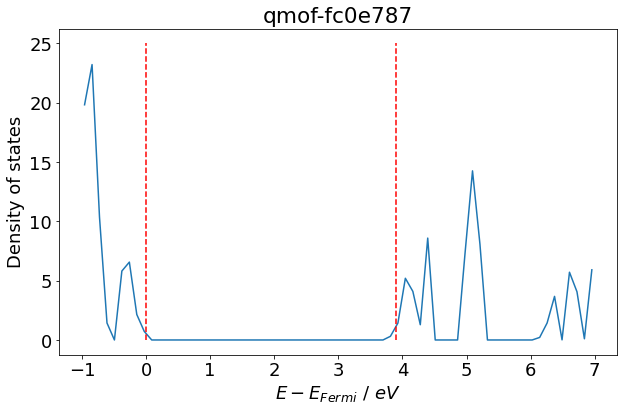

In [220]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.plot(energies[(energies>efermi-1) & (energies<efermi+7)]-efermi, dos_data[:, 1][(energies>efermi-1) & (energies<efermi+7)])
ax.plot([0,0], [0,25], 'r--')
ax.plot([bandgap, bandgap], [0,25], 'r--')
ax.set_xlabel("$E-E_{Fermi}\ /\ eV$")
ax.set_ylabel("Density of states")
ax.set_title("%s" %qmof_id)


In [210]:
bandgap_data = dos_data[(dos_data[:,0] > efermi) & (dos_data[:,0]<efermi+bandgap)][:-1]
#bandgap_data = bandgap_data[:-1]

In [221]:
sum(bandgap_data[:,1]>0)

0

In [211]:
bandgap_data

array([[  0.218,   0.   , 116.   ],
       [  0.335,   0.   , 116.   ],
       [  0.451,   0.   , 116.   ],
       [  0.567,   0.   , 116.   ],
       [  0.684,   0.   , 116.   ],
       [  0.8  ,   0.   , 116.   ],
       [  0.917,   0.   , 116.   ],
       [  1.033,   0.   , 116.   ],
       [  1.149,   0.   , 116.   ],
       [  1.266,   0.   , 116.   ],
       [  1.382,   0.   , 116.   ],
       [  1.499,   0.   , 116.   ],
       [  1.615,   0.   , 116.   ],
       [  1.731,   0.   , 116.   ],
       [  1.848,   0.   , 116.   ],
       [  1.964,   0.   , 116.   ],
       [  2.081,   0.   , 116.   ],
       [  2.197,   0.   , 116.   ],
       [  2.314,   0.   , 116.   ],
       [  2.43 ,   0.   , 116.   ],
       [  2.546,   0.   , 116.   ],
       [  2.663,   0.   , 116.   ],
       [  2.779,   0.   , 116.   ],
       [  2.896,   0.   , 116.   ],
       [  3.012,   0.   , 116.   ],
       [  3.128,   0.   , 116.   ],
       [  3.245,   0.   , 116.   ],
       [  3.361,   0.   , 11